# Eina per optimitzar carteres d'inversió

S'ha estudiat el comportament de tres mètodes d'optimització de carteres, per una banda, el mètode clàssic de Markowitz i per l'altre els mètodes d'aprenentatge computacional basats en Random Forest i LSTM. Al mateix temps s'ha estudiat l'impacte d'una diversificació forçada en els diferents mètodes, i s'han avaluat els rendiments obtinguts mitjançant un backtesting.

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

2025-06-08 17:49:19.280337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749397759.305633  323233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749397759.313527  323233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749397759.334408  323233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749397759.334434  323233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749397759.334438  323233 computation_placer.cc:177] computation placer alr

#### Configuració

In [2]:
# Configuració de visualització
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Afegir llavor per a la reproductibilitat 
seed_value = 33
np.random.seed(seed_value) 
tf.random.set_seed(seed_value) 
import random
random.seed(seed_value)

#### Optimitzador Base

In [3]:
class PortfolioOptimizer:
    """Classe base per a optimització de carteres"""
    
    def __init__(self, returns_data: pd.DataFrame, risk_free_rate: float = 0.02, 
                 hhi_penalty: float = 0.0):
        self.returns = returns_data
        self.risk_free_rate = risk_free_rate
        self.n_assets = len(returns_data.columns)
        self.asset_names = returns_data.columns.tolist()
        self.weights = None
        self.hhi_penalty = hhi_penalty  # Factor de penalització HHI
        
    def calculate_hhi(self, weights: np.array) -> float:
        """Calcula l'índex Herfindahl-Hirschman"""
        return np.sum(weights ** 2)
    
    def calculate_portfolio_metrics(self, weights: np.array) -> tuple:
        """Calcula rendiment i risc del portfolio"""
        portfolio_return = np.sum(weights * self.returns.mean()) * 252  # Anualitat
        portfolio_variance = np.dot(weights.T, np.dot(self.returns.cov() * 252, weights))
        portfolio_std = np.sqrt(portfolio_variance)
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std
        hhi = self.calculate_hhi(weights)
        return portfolio_return, portfolio_std, sharpe_ratio, hhi

#### Optimitzador de Markowitz

In [4]:
class MarkowitzOptimizer(PortfolioOptimizer):
    """Implementació de l'optimitzador de Markowitz amb penalització HHI"""
    
    def __init__(self, returns_data: pd.DataFrame, risk_free_rate: float = 0.02, 
                 hhi_penalty: float = 0.0):
        super().__init__(returns_data, risk_free_rate, hhi_penalty)
        self.mu = self.returns.mean().values
        self.sigma = self.returns.cov().values
        
    def objective_function(self, weights: np.array) -> float:
        """Funció objectiu: maximitzar Sharpe ratio penalitzat per HHI"""
        portfolio_return = np.dot(weights, self.mu) * 252
        portfolio_variance = np.dot(weights.T, np.dot(self.sigma * 252, weights))
        portfolio_std = np.sqrt(portfolio_variance)
        
        if portfolio_std == 0:
            return np.inf
        
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_std
        hhi = self.calculate_hhi(weights)
        
        # Penalització HHI: restem HHI ponderat pel factor de penalització
        penalized_objective = sharpe_ratio - self.hhi_penalty * hhi
        
        return -penalized_objective  # Negatiu perquè minimitzem
    
    def optimize(self) -> np.array:
        """Optimitza la cartera utilitzant el mètode de Markowitz amb penalització HHI"""
        # Restriccions
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Suma = 1
        bounds = tuple((0, 1) for _ in range(self.n_assets))  # No short selling
        
        # Punt inicial
        initial_guess = np.array([1/self.n_assets] * self.n_assets)
        
        # Optimització
        result = minimize(
            self.objective_function,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False}
        )
        
        if result.success:
            self.weights = result.x
            return result.x
        else:
            print("L'optimització no ha convergit. Utilitzant pesos iguals.")
            self.weights = initial_guess
            return initial_guess

#### Optimitzador Random Forest

In [5]:
class RandomForestOptimizer(PortfolioOptimizer):
    """Optimitzador basat en Random Forest amb penalització HHI"""
    
    def __init__(self, returns_data: pd.DataFrame, risk_free_rate: float = 0.02, 
                 lookback_period: int = 30, hhi_penalty: float = 0.0):
        super().__init__(returns_data, risk_free_rate, hhi_penalty)
        self.lookback_period = lookback_period
        self.models = {}
        self.predictions = None
        
    def prepare_features(self, data: pd.Series, lookback: int) -> tuple:
        """Prepara les característiques pel model"""
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data.iloc[i-lookback:i].values)
            y.append(data.iloc[i])
        return np.array(X), np.array(y)
    
    def train_models(self) -> dict:
        """Entrena un model Random Forest per cada actiu"""
        for asset in self.asset_names:
            X, y = self.prepare_features(self.returns[asset], self.lookback_period)
            
            if len(X) > 0:
                model = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=10,
                    # Aquí s'afegeix la llavor per a la reproductibilitat
                    random_state=seed_value, 
                    n_jobs=-1
                )
                model.fit(X, y)
                self.models[asset] = model
            
        return self.models
    
    def predict_returns(self) -> np.array:
        """Prediu els rendiments futurs utilitzant els models entrenats"""
        predictions = []
        
        for asset in self.asset_names:
            if asset in self.models:
                # Utilitzem les últimes observacions per fer la predicció
                last_data = self.returns[asset].tail(self.lookback_period).values
                pred = self.models[asset].predict(last_data.reshape(1, -1))[0]
                predictions.append(pred)
            else:
                predictions.append(0)
        
        self.predictions = np.array(predictions)
        return self.predictions
    
    def optimize_with_hhi_penalty(self, predicted_returns: np.array) -> np.array:
        """Optimitza tenint en compte les prediccions i la penalització HHI"""
        def objective(weights):
            portfolio_return = np.dot(weights, predicted_returns) * 252
            hhi = self.calculate_hhi(weights)
            # Maximitzem rendiment i minimitzem concentració
            return -(portfolio_return - self.hhi_penalty * hhi)
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        initial_guess = np.array([1/self.n_assets] * self.n_assets)
        
        result = minimize(
            objective,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False}
        )
        
        return result.x if result.success else initial_guess
    
    def optimize(self) -> np.array:
        """Optimitza utilitzant les prediccions de Random Forest amb penalització HHI"""
        # Entrena els models
        self.train_models()
        
        # Prediu rendiments
        predicted_returns = self.predict_returns()
        
        if self.hhi_penalty > 0:
            # Optimització amb penalització HHI
            weights = self.optimize_with_hhi_penalty(predicted_returns)
        else:
            # Optimització tradicional basada en prediccions
            positive_returns = np.maximum(predicted_returns, 0)
            
            if np.sum(positive_returns) > 0:
                weights = positive_returns / np.sum(positive_returns)
            else:
                weights = np.array([1/self.n_assets] * self.n_assets)
        
        self.weights = weights
        return weights

#### Optimitzador LSTM

In [6]:
class LSTMOptimizer(PortfolioOptimizer):
    """Optimitzador basat en LSTM amb penalització HHI"""
    
    def __init__(self, returns_data: pd.DataFrame, risk_free_rate: float = 0.02,
                 sequence_length: int = 30, epochs: int = 50, hhi_penalty: float = 0.0):
        super().__init__(returns_data, risk_free_rate, hhi_penalty)
        self.sequence_length = sequence_length
        self.epochs = epochs
        self.models = {}
        self.scalers = {}
        self.predictions = None
        
    def prepare_lstm_data(self, data: pd.Series) -> tuple:
        """Prepara les dades per al model LSTM"""
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
        
        X, y = [], []
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i-self.sequence_length:i, 0])
            y.append(scaled_data[i, 0])
            
        return np.array(X), np.array(y), scaler
    
    def create_lstm_model(self) -> Sequential:
        """Crea el model LSTM"""
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(self.sequence_length, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model
    
    def train_models(self) -> dict:
        """Entrena un model LSTM per cada actiu"""
        for asset in self.asset_names:
            try:
                X, y, scaler = self.prepare_lstm_data(self.returns[asset])
                
                if len(X) > 0:
                    X = X.reshape((X.shape[0], X.shape[1], 1))
                    
                    model = self.create_lstm_model()
                    model.fit(X, y, epochs=self.epochs, batch_size=32, verbose=0)
                    
                    self.models[asset] = model
                    self.scalers[asset] = scaler
                    
            except Exception as e:
                print(f"Error entrenant model LSTM per {asset}: {e}")
        
        return self.models
    
    def predict_returns(self) -> np.array:
        """Prediu els rendiments futurs utilitzant els models LSTM"""
        predictions = []
        
        for asset in self.asset_names:
            if asset in self.models and asset in self.scalers:
                try:
                    # Prepara les últimes dades
                    last_data = self.returns[asset].tail(self.sequence_length).values
                    scaled_data = self.scalers[asset].transform(last_data.reshape(-1, 1))
                    X_pred = scaled_data.reshape((1, self.sequence_length, 1))
                    
                    # Predicció
                    pred_scaled = self.models[asset].predict(X_pred, verbose=0)
                    pred = self.scalers[asset].inverse_transform(pred_scaled)[0][0]
                    predictions.append(pred)
                    
                except Exception as e:
                    print(f"Error predint per {asset}: {e}")
                    predictions.append(0)
            else:
                predictions.append(0)
        
        self.predictions = np.array(predictions)
        return self.predictions
    
    def optimize_with_hhi_penalty(self, predicted_returns: np.array) -> np.array:
        """Optimitza tenint en compte les prediccions i la penalització HHI"""
        def objective(weights):
            portfolio_return = np.dot(weights, predicted_returns) * 252
            hhi = self.calculate_hhi(weights)
            # Maximitzem rendiment i minimitzem concentració
            return -(portfolio_return - self.hhi_penalty * hhi)
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        initial_guess = np.array([1/self.n_assets] * self.n_assets)
        
        result = minimize(
            objective,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False}
        )
        
        return result.x if result.success else initial_guess
    
    def optimize(self) -> np.array:
        """Optimitza utilitzant les prediccions LSTM amb penalització HHI"""
        # Entrena els models
        self.train_models()
        
        # Prediu rendiments
        predicted_returns = self.predict_returns()
        
        if self.hhi_penalty > 0:
            # Optimització amb penalització HHI
            weights = self.optimize_with_hhi_penalty(predicted_returns)
        else:
            # Optimització tradicional basada en prediccions
            positive_returns = np.maximum(predicted_returns, 0)
            
            if np.sum(positive_returns) > 0:
                weights = positive_returns / np.sum(positive_returns)
            else:
                weights = np.array([1/self.n_assets] * self.n_assets)
        
        self.weights = weights
        return weights

#### Backtesting

In [7]:
class BacktestEngine:
    """Motor de backtesting per avaluar els portfolios"""
    
    def __init__(self, returns_data: pd.DataFrame, benchmark_returns: pd.Series = None):
        self.returns = returns_data
        self.benchmark = benchmark_returns
        
    def backtest_portfolio(self, weights: np.array, start_date: str = None) -> pd.Series:
        """Executa el backtesting d'un portfolio"""
        if start_date:
            test_returns = self.returns.loc[start_date:]
        else:
            test_returns = self.returns
            
        portfolio_returns = (test_returns * weights).sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        
        return portfolio_returns, cumulative_returns
    
    def calculate_metrics(self, portfolio_returns: pd.Series, weights: np.array = None) -> dict:
        """Calcula les mètriques de rendiment incloent HHI"""
        total_return = (1 + portfolio_returns).prod() - 1
        annual_return = (1 + portfolio_returns.mean()) ** 252 - 1
        annual_volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0
        
        # Drawdown màxim
        cumulative = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # HHI si es proporcionen els pesos
        hhi = np.sum(weights ** 2) if weights is not None else None
        
        metrics = {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Annual Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown
        }
        
        if hhi is not None:
            metrics['HHI'] = hhi
            
        return metrics

#### Cas d'us

In [8]:
# Carrega de dades
try:
    dades = pd.read_csv('dades_borses.csv', index_col=0, parse_dates=True)
except FileNotFoundError:
    print("Error: 'dades_borses.csv' no trobat. Assegura't que el fitxer és al mateix directori.")
    exit()

tickers = dades.columns.tolist()
print(f"Actius carregats: {tickers}")

def calcula_rendiments(dades_preus: pd.DataFrame) -> pd.DataFrame:
    """Calcula els rendiments logarítmics diaris a partir de les dades de preus de tancament."""
    return np.log(dades_preus / dades_preus.shift(1)).dropna()

rendiments = calcula_rendiments(dades)
print(f"Dimensions dels rendiments: {rendiments.shape}")

Actius carregats: ['SAP.DE', 'BAYN.DE', 'BMW.DE', 'ALV.DE', 'DTE.DE', 'VOW3.DE', 'ADS.DE', 'FRE.DE', 'DBK.DE', 'MUV2.DE']
Dimensions dels rendiments: (1271, 10)


In [9]:
# Dividim les dades en entrenament i test
split_date = rendiments.index[int(len(rendiments) * 0.8)]
train_data = rendiments.loc[:split_date]
test_data = rendiments.loc[split_date:]

print(f"Dades d'entrenament: {train_data.shape}")
print(f"Dades de test: {len(test_data)} dies")

Dades d'entrenament: (1017, 10)
Dades de test: 255 dies


In [10]:
# Paràmetres de configuració
risk_free_rate = 0.0385
hhi_penalty_factor = 0.5
print(f"\nFactor de penalització HHI: {hhi_penalty_factor}")


Factor de penalització HHI: 0.5


In [11]:
# Inicialitza els optimitzadors sense penalització HHI
markowitz = MarkowitzOptimizer(train_data, risk_free_rate, hhi_penalty=0.0)
random_forest = RandomForestOptimizer(train_data, risk_free_rate, hhi_penalty=0.0)
lstm = LSTMOptimizer(train_data, risk_free_rate, epochs=30, hhi_penalty=0.0)


In [12]:
# Inicialitza els optimitzadors amb penalització HHI
markowitz_hhi = MarkowitzOptimizer(train_data, risk_free_rate, hhi_penalty=hhi_penalty_factor)
random_forest_hhi = RandomForestOptimizer(train_data, risk_free_rate, hhi_penalty=hhi_penalty_factor)
lstm_hhi = LSTMOptimizer(train_data, risk_free_rate, epochs=30, hhi_penalty=hhi_penalty_factor)

In [13]:
# Optimitza les carteres sense penalització HHI
print("Optimitzant carteres sense penalització HHI...")
weights_markowitz = markowitz.optimize()
weights_rf = random_forest.optimize()
weights_lstm = lstm.optimize()

Optimitzant carteres sense penalització HHI...


2025-06-08 17:49:40.517468: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
# Optimitza les carteres amb penalització HHI
print("Optimitzant carteres amb penalització HHI...")
weights_markowitz_hhi = markowitz_hhi.optimize()
weights_rf_hhi = random_forest_hhi.optimize()
weights_lstm_hhi = lstm_hhi.optimize()

Optimitzant carteres amb penalització HHI...


In [15]:
# Crea el DataFrame amb els pesos
weights_df = pd.DataFrame({
    'Markowitz': weights_markowitz,
    'Random Forest': weights_rf,
    'LSTM': weights_lstm,
    'Markowitz + HHI': weights_markowitz_hhi,
    'Random Forest + HHI': weights_rf_hhi,
    'LSTM + HHI': weights_lstm_hhi
}, index=tickers)

print("\nPesos de les carteres:")
print(weights_df.round(4))


Pesos de les carteres:
         Markowitz  Random Forest    LSTM  Markowitz + HHI  \
SAP.DE         0.0         0.0400  0.0000           0.0499   
BAYN.DE        0.0         0.3017  0.0000           0.0000   
BMW.DE         0.0         0.1186  0.0000           0.1643   
ALV.DE         0.0         0.0860  0.4311           0.1006   
DTE.DE         0.0         0.2208  0.1255           0.2224   
VOW3.DE        0.0         0.0000  0.0000           0.0000   
ADS.DE         0.0         0.0000  0.1881           0.0000   
FRE.DE         0.0         0.0000  0.0000           0.0000   
DBK.DE         0.0         0.0000  0.0000           0.0950   
MUV2.DE        1.0         0.2328  0.2553           0.3678   

         Random Forest + HHI  LSTM + HHI  
SAP.DE                0.0000      0.0000  
BAYN.DE               0.3528      0.0000  
BMW.DE                0.0979      0.0523  
ALV.DE                0.0525      0.0000  
DTE.DE                0.2401      0.0917  
VOW3.DE               0.0000      0

In [16]:
# Calcula i mostra l'HHI per cada cartera
print("\nÍndex HHI (Herfindahl-Hirschman) per cada cartera:")
for col in weights_df.columns:
    hhi = np.sum(weights_df[col] ** 2)
    print(f"{col}: {hhi:.4f}")


Índex HHI (Herfindahl-Hirschman) per cada cartera:
Markowitz: 1.0000
Random Forest: 0.2171
LSTM: 0.3021
Markowitz + HHI: 0.2334
Random Forest + HHI: 0.2604
LSTM + HHI: 0.3853


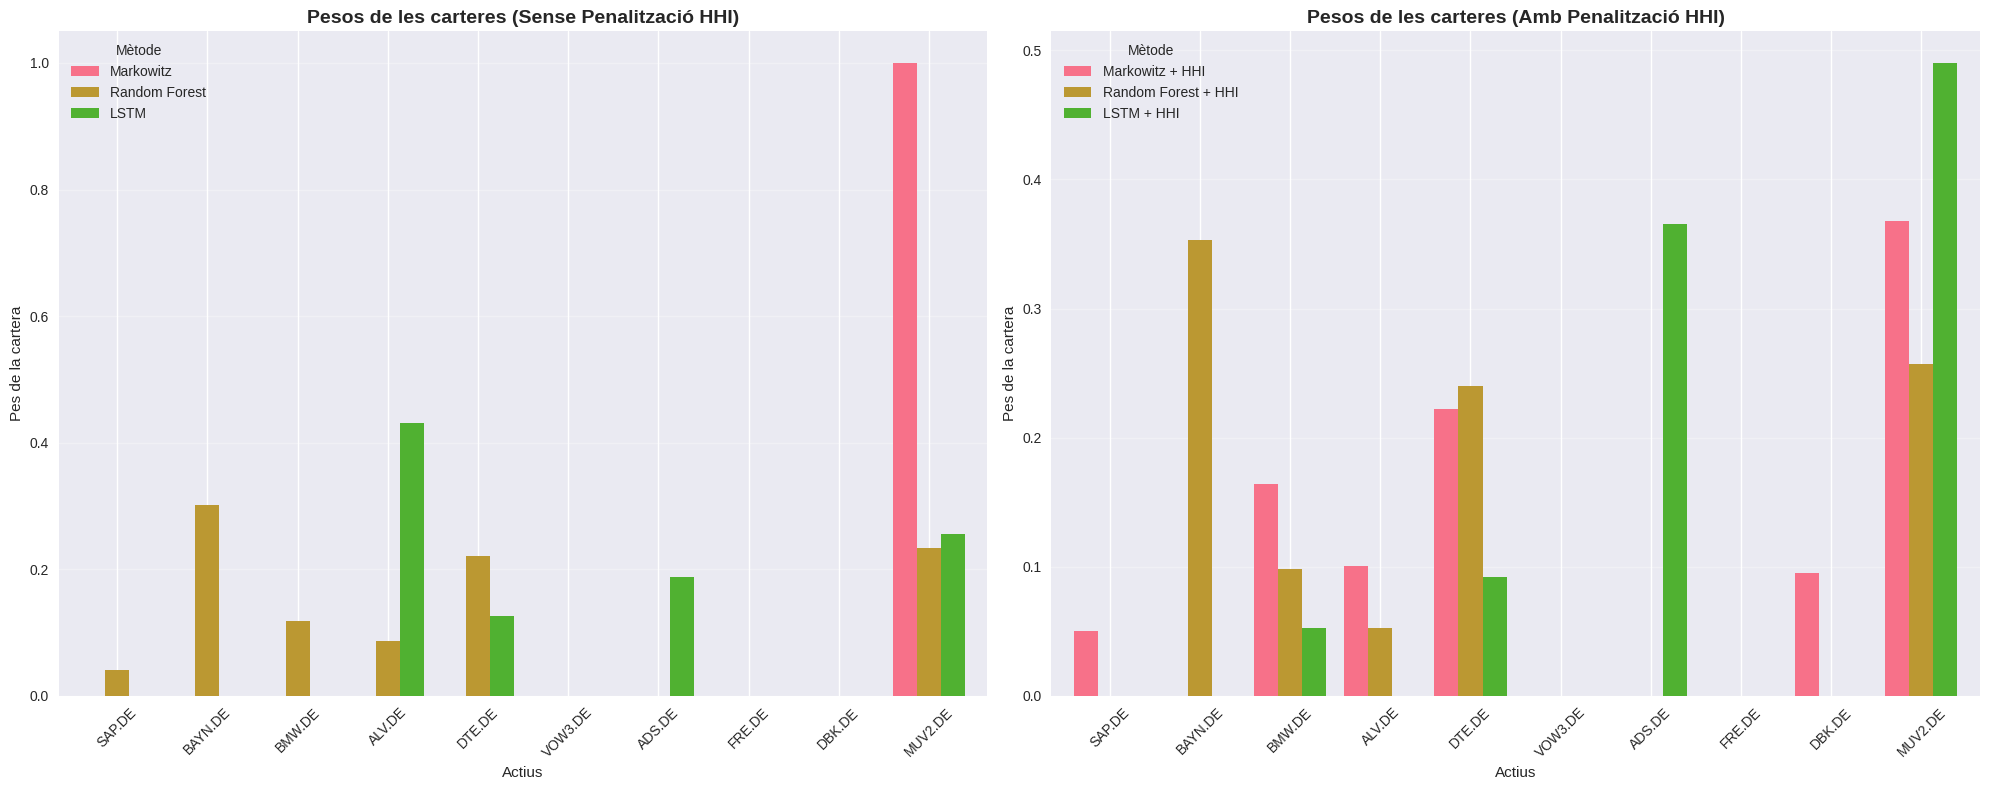

In [29]:
# Visualització dels pesos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# Gràfic sense penalització HHI
weights_df[['Markowitz', 'Random Forest', 'LSTM']].plot(kind='bar', width=0.8, ax=ax1)
ax1.set_title('Pesos de les carteres (Sense Penalització HHI)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Actius')
ax1.set_ylabel('Pes de la cartera')
ax1.legend(title='Mètode')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Gràfic amb penalització HHI
weights_df[['Markowitz + HHI', 'Random Forest + HHI', 'LSTM + HHI']].plot(kind='bar', width=0.8, ax=ax2)
ax2.set_title('Pesos de les carteres (Amb Penalització HHI)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Actius')
ax2.set_ylabel('Pes de la cartera')
ax2.legend(title='Mètode')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('PesosCarteres.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [19]:
# Backtesting
backtest_engine = BacktestEngine(test_data)

In [20]:
# Executa backtesting per cada mètode
results = {}
weight_sets = {
    'Markowitz': weights_markowitz,
    'Random Forest': weights_rf,
    'LSTM': weights_lstm,
    'Markowitz + HHI': weights_markowitz_hhi,
    'Random Forest + HHI': weights_rf_hhi,
    'LSTM + HHI': weights_lstm_hhi
}

In [21]:
# Benchmark: cartera amb pesos iguals
equal_weights = np.array([1/len(tickers)] * len(tickers))
weight_sets['Benchmark (Equal Weight)'] = equal_weights

for name, weights in weight_sets.items():
    returns, cum_returns = backtest_engine.backtest_portfolio(weights)
    results[name] = {
        'returns': returns,
        'cumulative': cum_returns,
        'metrics': backtest_engine.calculate_metrics(returns, weights)
    }

In [22]:
# Crea taula de resultats
results_df = pd.DataFrame({name: data['metrics'] for name, data in results.items()}).T

print("\nResultats del Backtesting:")
print(results_df.round(4))


Resultats del Backtesting:
                          Total Return  Annual Return  Annual Volatility  \
Markowitz                       0.2561         0.2739             0.1828   
Random Forest                   0.0614         0.0707             0.1372   
LSTM                            0.2805         0.2913             0.1504   
Markowitz + HHI                 0.2566         0.2637             0.1291   
Random Forest + HHI             0.0225         0.0332             0.1456   
LSTM + HHI                      0.3129         0.3283             0.1728   
Benchmark (Equal Weight)        0.1822         0.1914             0.1395   

                          Sharpe Ratio  Max Drawdown     HHI  
Markowitz                       1.4981       -0.1057  1.0000  
Random Forest                   0.5153       -0.1456  0.2171  
LSTM                            1.9365       -0.0829  0.3021  
Markowitz + HHI                 2.0428       -0.0789  0.2334  
Random Forest + HHI             0.2280       -0.

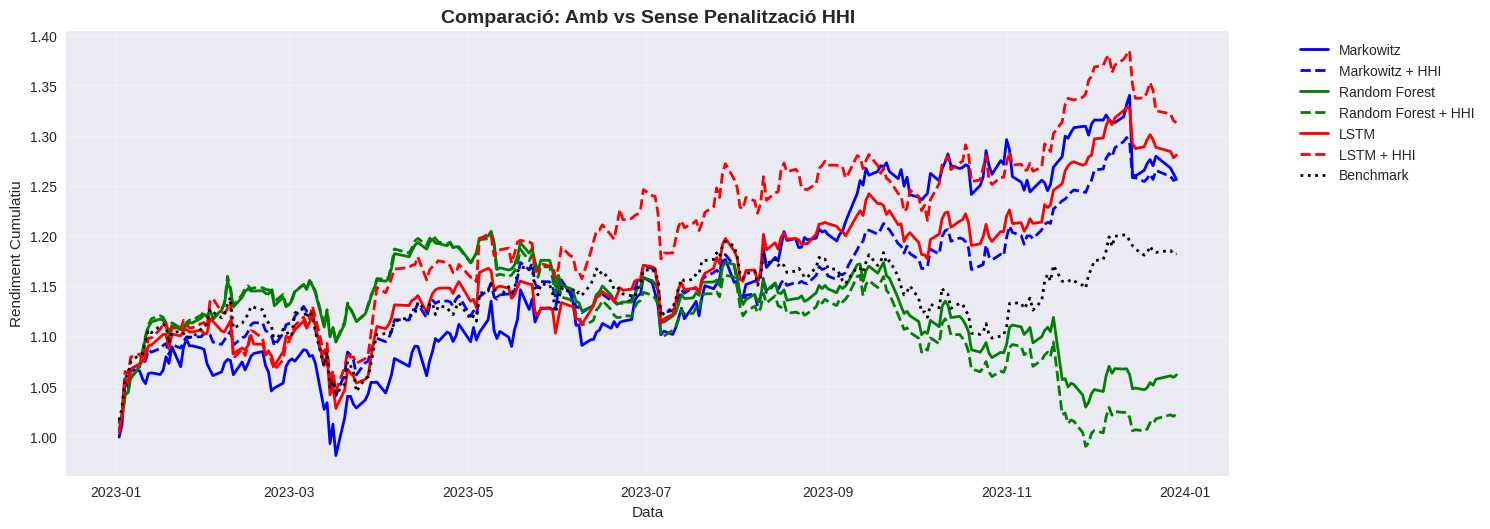

In [31]:
# Gràfic de rendiments cumulatius
plt.figure(figsize=(15, 10))

# Comparació amb/sense HHI
plt.subplot(2, 1, 2)
methods = ['Markowitz', 'Random Forest', 'LSTM']
colors = ['blue', 'green', 'red']

for i, method in enumerate(methods):
    # Sense HHI
    plt.plot(results[method]['cumulative'].index, results[method]['cumulative'].values, 
             label=f'{method}', color=colors[i], linewidth=2, linestyle='-')
    # Amb HHI
    plt.plot(results[f'{method} + HHI']['cumulative'].index, results[f'{method} + HHI']['cumulative'].values, 
             label=f'{method} + HHI', color=colors[i], linewidth=2, linestyle='--')

plt.plot(results['Benchmark (Equal Weight)']['cumulative'].index, 
         results['Benchmark (Equal Weight)']['cumulative'].values, 
         label='Benchmark', color='black', linewidth=2, linestyle=':')

plt.title('Comparació: Amb vs Sense Penalització HHI', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Rendiment Cumulatiu')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Comparació.pdf', bbox_inches='tight', dpi=300)
plt.show()

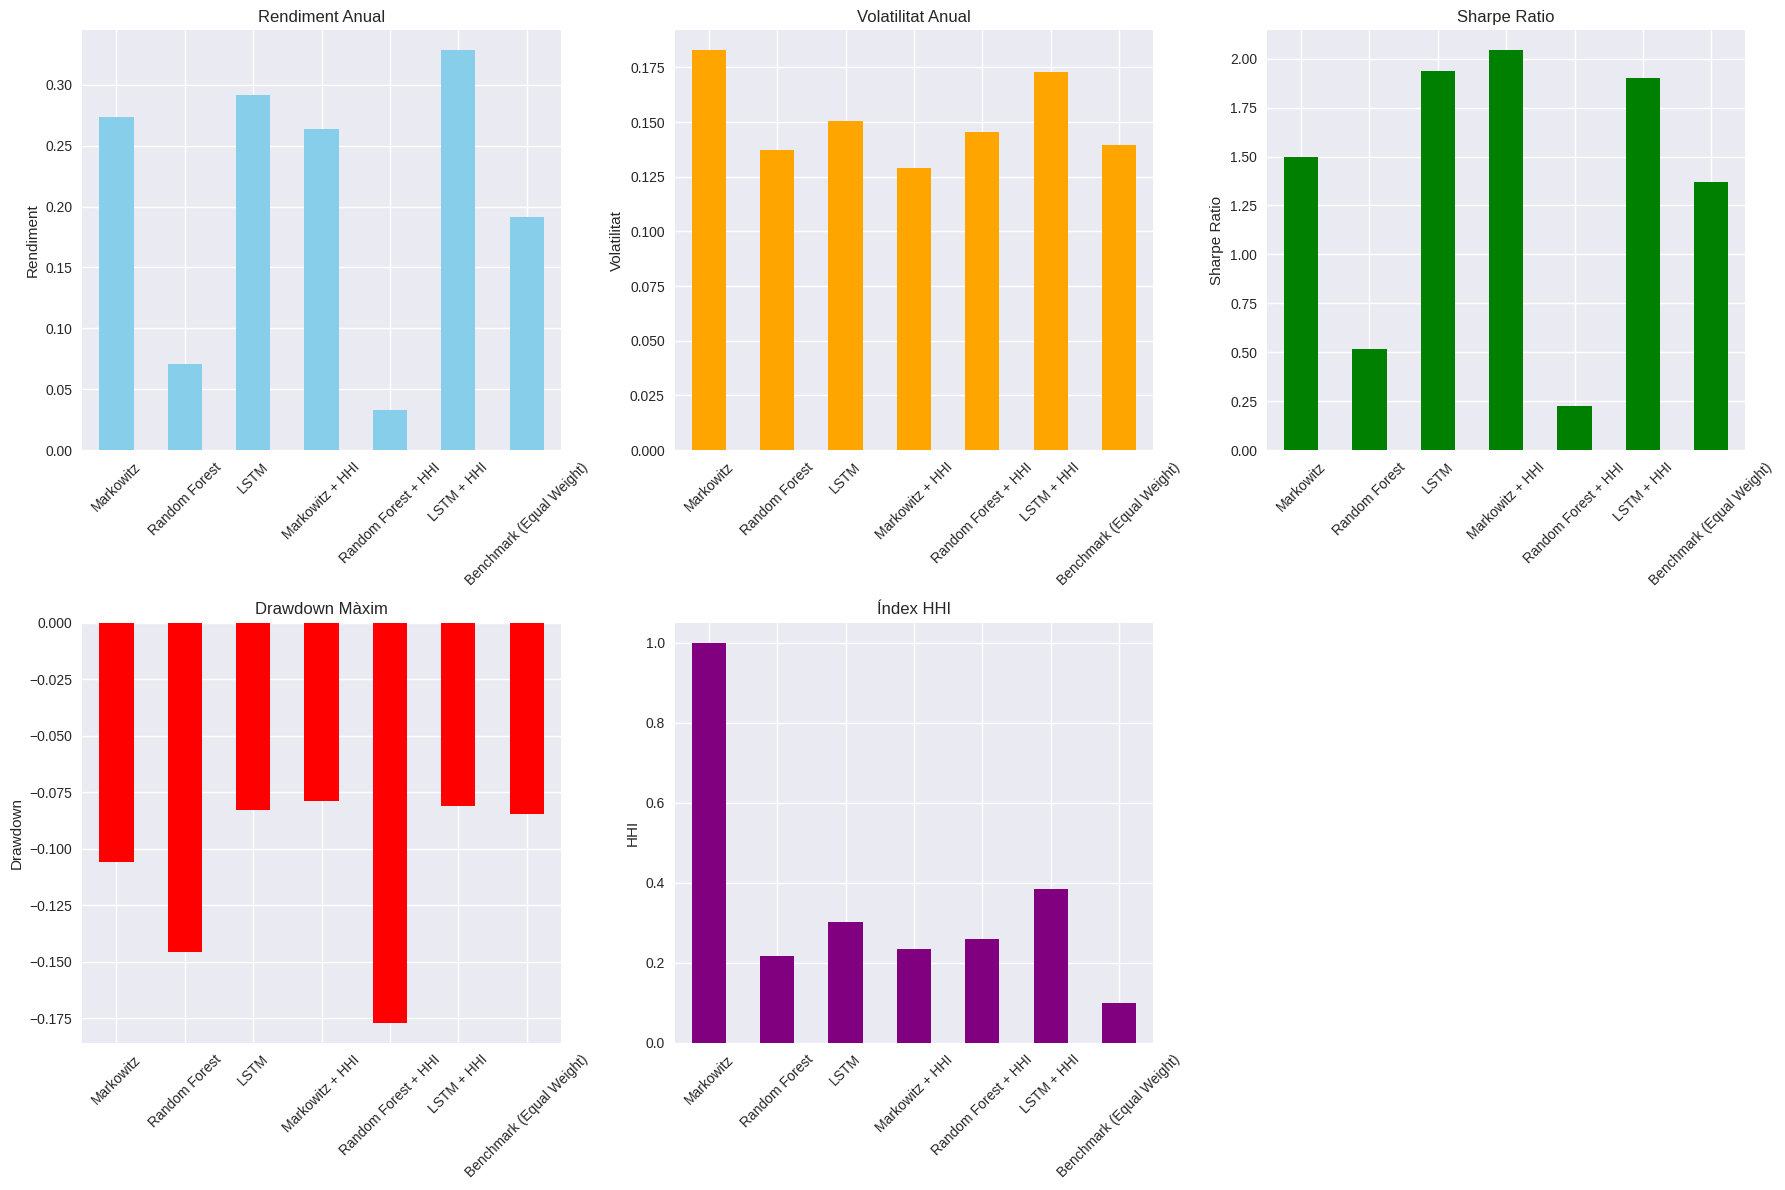

In [36]:
# Gràfic de barres per les mètriques clau incloent HHI
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Rendiment anual
results_df['Annual Return'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Rendiment Anual')
axes[0,0].set_ylabel('Rendiment')
axes[0,0].tick_params(axis='x', rotation=45)

# Volatilitat anual
results_df['Annual Volatility'].plot(kind='bar', ax=axes[0,1], color='orange')
axes[0,1].set_title('Volatilitat Anual')
axes[0,1].set_ylabel('Volatilitat')
axes[0,1].tick_params(axis='x', rotation=45)

# Sharpe Ratio
results_df['Sharpe Ratio'].plot(kind='bar', ax=axes[0,2], color='green')
axes[0,2].set_title('Sharpe Ratio')
axes[0,2].set_ylabel('Sharpe Ratio')
axes[0,2].tick_params(axis='x', rotation=45)

# Max Drawdown
results_df['Max Drawdown'].plot(kind='bar', ax=axes[1,0], color='red')
axes[1,0].set_title('Drawdown Màxim')
axes[1,0].set_ylabel('Drawdown')
axes[1,0].tick_params(axis='x', rotation=45)

# HHI
results_df['HHI'].plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Índex HHI')
axes[1,1].set_ylabel('HHI')
axes[1,1].tick_params(axis='x', rotation=45)

# Eliminar el subplot buit
fig.delaxes(axes[1,2])

plt.tight_layout()
plt.savefig('Cinc.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
print("\nAnàlisi completada!")
print(f"El millor mètode segons Sharpe Ratio: {results_df['Sharpe Ratio'].idxmax()}")
print(f"El mètode amb menor volatilitat: {results_df['Annual Volatility'].idxmin()}")
print(f"El mètode amb menor drawdown: {results_df['Max Drawdown'].idxmax()}")
print(f"El mètode més diversificat (menor HHI): {results_df['HHI'].idxmin()}")
print(f"El mètode menys diversificat (major HHI): {results_df['HHI'].idxmax()}")


Anàlisi completada!
El millor mètode segons Sharpe Ratio: Markowitz + HHI
El mètode amb menor volatilitat: Markowitz + HHI
El mètode amb menor drawdown: Markowitz + HHI
El mètode més diversificat (menor HHI): Benchmark (Equal Weight)
El mètode menys diversificat (major HHI): Markowitz


In [26]:
# Anàlisi de l'efecte de la penalització HHI
print("\n" + "="*60)
print("ANÀLISI DE L'EFECTE DE LA PENALITZACIÓ HHI")
print("="*60)

for method in ['Markowitz', 'Random Forest', 'LSTM']:
    original = results_df.loc[method]
    penalized = results_df.loc[f'{method} + HHI']
    
    print(f"\n{method}:")
    print(f"  HHI: {original['HHI']:.4f} → {penalized['HHI']:.4f} (Δ: {penalized['HHI'] - original['HHI']:.4f})")
    print(f"  Sharpe: {original['Sharpe Ratio']:.4f} → {penalized['Sharpe Ratio']:.4f} (Δ: {penalized['Sharpe Ratio'] - original['Sharpe Ratio']:.4f})")
    print(f"  Rendiment: {original['Annual Return']:.4f} → {penalized['Annual Return']:.4f} (Δ: {penalized['Annual Return'] - original['Annual Return']:.4f})")
    print(f"  Volatilitat: {original['Annual Volatility']:.4f} → {penalized['Annual Volatility']:.4f} (Δ: {penalized['Annual Volatility'] - original['Annual Volatility']:.4f})")


ANÀLISI DE L'EFECTE DE LA PENALITZACIÓ HHI

Markowitz:
  HHI: 1.0000 → 0.2334 (Δ: -0.7666)
  Sharpe: 1.4981 → 2.0428 (Δ: 0.5446)
  Rendiment: 0.2739 → 0.2637 (Δ: -0.0102)
  Volatilitat: 0.1828 → 0.1291 (Δ: -0.0537)

Random Forest:
  HHI: 0.2171 → 0.2604 (Δ: 0.0433)
  Sharpe: 0.5153 → 0.2280 (Δ: -0.2873)
  Rendiment: 0.0707 → 0.0332 (Δ: -0.0375)
  Volatilitat: 0.1372 → 0.1456 (Δ: 0.0085)

LSTM:
  HHI: 0.3021 → 0.3853 (Δ: 0.0831)
  Sharpe: 1.9365 → 1.9003 (Δ: -0.0361)
  Rendiment: 0.2913 → 0.3283 (Δ: 0.0370)
  Volatilitat: 0.1504 → 0.1728 (Δ: 0.0223)
